### Base settings

In [1]:
%load_ext autoreload
%autoreload 2

import time
from pprint import pprint
from pathlib import Path
from collections import OrderedDict
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torchvision.transforms as transforms

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# create ConfigDict from config yaml file
import yaml
from ml_collections import config_dict

config_path = Path('configs') / 'deit_tiny-pretrained-cifar100.yaml'
with config_path.open('r') as f:
    config = yaml.safe_load(f)
    config = config_dict.ConfigDict(config)

In [3]:
# frequently used variables
model_name = config.model.name
patch_size = config.model.patch_size
summary = config.summary

# log directories
log_root = Path('./logs') / model_name / summary
checkpoint_path = log_root / 'checkpoints'

In [4]:
# initialize ViT model and load pretrained weights
from ood_with_vit.models.vit import ViT

def initialize_vit_model(config, verbose=0):
    assert config.model.pretrained, 'only pretrained models are allowed'
    if config.model.pretrained:
        model = torch.hub.load(
            repo_or_dir=config.model.repo,
            model=config.model.pretrained_model,
            pretrained=True,
        )
    model = model.to(device=device)
    if verbose:
        print(model)
        
    return model

In [5]:
from torchvision.datasets import CIFAR10, CIFAR100
from torch.utils.data import DataLoader, Dataset

dataset_mean, dataset_std = config.dataset.mean, config.dataset.std
dataset_root = config.dataset.root
img_size = config.model.img_size

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      

cifar10 = CIFAR10(
    root=dataset_root, 
    train=False, 
    download=False, 
    transform=transform_test
)
cifar10_test_dataloader = DataLoader(
    dataset=cifar10, 
    batch_size=config.eval.batch_size, 
    shuffle=False, 
    num_workers=8
)

cifar100 = CIFAR100(
    root=dataset_root, 
    train=False, 
    download=False, 
    transform=transform_test
)
cifar100_test_dataloader = DataLoader(
    dataset=cifar100, 
    batch_size=config.eval.batch_size, 
    shuffle=False, 
    num_workers=8
)

print(cifar10.class_to_idx)
print(cifar100.class_to_idx)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
{'apple': 0, 'aquarium_fish': 1, 'baby': 2, 'bear': 3, 'beaver': 4, 'bed': 5, 'bee': 6, 'beetle': 7, 'bicycle': 8, 'bottle': 9, 'bowl': 10, 'boy': 11, 'bridge': 12, 'bus': 13, 'butterfly': 14, 'camel': 15, 'can': 16, 'castle': 17, 'caterpillar': 18, 'cattle': 19, 'chair': 20, 'chimpanzee': 21, 'clock': 22, 'cloud': 23, 'cockroach': 24, 'couch': 25, 'crab': 26, 'crocodile': 27, 'cup': 28, 'dinosaur': 29, 'dolphin': 30, 'elephant': 31, 'flatfish': 32, 'forest': 33, 'fox': 34, 'girl': 35, 'hamster': 36, 'house': 37, 'kangaroo': 38, 'keyboard': 39, 'lamp': 40, 'lawn_mower': 41, 'leopard': 42, 'lion': 43, 'lizard': 44, 'lobster': 45, 'man': 46, 'maple_tree': 47, 'motorcycle': 48, 'mountain': 49, 'mouse': 50, 'mushroom': 51, 'oak_tree': 52, 'orange': 53, 'orchid': 54, 'otter': 55, 'palm_tree': 56, 'pear': 57, 'pickup_truck': 58, 'pine_tree': 59, 'plain': 60, 'plate': 61, '

### Utility

In [6]:
# set seeds
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
seed = 1234

### Visualize features

In [7]:
import cv2

def apply_mask_on_img(img, mask):
    img_h, img_w, _ = img.shape
    mask = cv2.resize(mask, (img_h, img_w), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)
    masked_img = img * (1 - mask)
    return masked_img

In [8]:
from ood_with_vit.simmim import SimMIMHooker
from ood_with_vit.visualizer.feature_extractor import FeatureExtractor

model = initialize_vit_model(config)
mask_ratio = 0.2
simmim = SimMIMHooker(
    config=config,
    model=model,
    patch_embedding_layer_name='patch_embed.norm',
    mask_ratio=mask_ratio,
)
simmim.hook()

# add hooks for feature extraction
feature_extractor = FeatureExtractor(
    model=model,
    layer_name=config.model.layer_name.penultimate,
)

Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main


name: patch_embed.norm


In [10]:
# gather penultimate features
from ood_with_vit.utils import compute_penultimate_features

set_seed(1234)
num_samples = 20
num_class = 10

print('processing in-distribution samples...')
X_cifar10, y_cifar10 = [], []
cifar10_img_paths = []
cls_indices = random.sample(range(len(cifar10.classes)), num_class)
for cls_idx in cls_indices:
    img_indices = np.where(np.array(cifar10.targets) == cls_idx)[0]
    img_indices = random.sample(list(img_indices), num_samples)
    for i in tqdm(img_indices):
        img, _ = cifar10[i]
        img = img.to(device)
        penultimate_features = compute_penultimate_features(
            config=config, 
            model=model, 
            imgs=img.unsqueeze(0),
            feature_extractor=feature_extractor,    
        )
        X_cifar10.append(penultimate_features.squeeze().numpy())
        y_cifar10.append((cls_idx, cifar10.classes[cls_idx]))
        # CHW => HWC
        original_img_path = f'./assets/cifar10/test/{i:05d}.jpg'
        original_img = cv2.imread(original_img_path)
        mask = simmim.get_mask()
        masked_img = apply_mask_on_img(original_img, mask)
        masked_img_path = f'./assets/cifar10/test/masked/{i:05d}.jpg'
        cv2.imwrite(masked_img_path, masked_img)
        cifar10_img_paths.append(masked_img_path)

print('processing out-of-distribution samples...')
X_cifar100, y_cifar100 = [], []
cifar100_img_paths = []
cls_indices = random.sample(range(len(cifar100.classes)), num_class)
for cls_idx in cls_indices:
    img_indices = np.where(np.array(cifar100.targets) == cls_idx)[0]
    img_indices = random.sample(list(img_indices), num_samples)
    for i in tqdm(img_indices):
        img, _ = cifar10[i]
        img = img.to(device)
        penultimate_features = compute_penultimate_features(
            config=config, 
            model=model, 
            imgs=img.unsqueeze(0),
            feature_extractor=feature_extractor,    
        )
        X_cifar100.append(penultimate_features.squeeze().numpy())
        y_cifar100.append((cls_idx, cifar100.classes[cls_idx]))
        # CHW => HWC
        original_img_path = f'./assets/cifar100/test/{i:05d}.jpg'
        original_img = cv2.imread(original_img_path)
        mask = simmim.get_mask()
        masked_img = apply_mask_on_img(original_img, mask)
        masked_img_path = f'./assets/cifar100/test/masked/{i:05d}.jpg'
        cv2.imwrite(masked_img_path, masked_img)
        cifar100_img_paths.append(masked_img_path)

processing in-distribution samples...


100%|██████████| 20/20 [00:00<00:00, 106.69it/s]


processing out-of-distribution samples...


100%|██████████| 20/20 [00:00<00:00, 104.65it/s]


#### Feature visualization by T-SNE

In [11]:
from ipywidgets import HTML, VBox

def interactive_plot(partitioned_info, fig, event="click") :
    """
    Make a plot react on hover or click of a data point and update a HTML preview below it.    
    """
    html = HTML("")
    fig = go.FigureWidget(data=fig.data, layout=fig.layout)

    if event == "hover" :
        for data in fig.data:
            def update(trace, points, state):
                if len(points.point_inds) == 0:
                    return
                trace_idx, point_idx = points.trace_index, points.point_inds[0]
                df_row = partitioned_info[trace_idx].iloc[point_idx]
                img_url = df_row['img']
                label = df_row['label']
                html.value = f'\
                    <body>\
                        <img src="{img_url}" width="240"><br>\
                        <b>Image: {img_url}</b><br>\
                        <b>Label: {label}</b>\
                    </body>'
            data.on_hover(update)
    else :
        for data in fig.data:
            def update(trace, points, state):
                if len(points.point_inds) == 0:
                    return
                trace_idx, point_idx = points.trace_index, points.point_inds[0]
                df_row = partitioned_info[trace_idx].iloc[point_idx]
                img_url = df_row['img']
                label = df_row['label']
                html.value = f'\
                    <body>\
                        <img src="{img_url}" width="240"><br>\
                        <b>Image: {img_url}</b><br>\
                        <b>Label: {label}</b>\
                    </body>'
            data.on_click(update)

    return VBox([fig, html])

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=seed)
X_tsne = tsne.fit_transform(X_cifar10)

df_embed = pd.DataFrame(X_tsne)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_cifar10)
df_embed = df_embed.assign(img=cifar10_img_paths)

partitioned_info, processed_labels = [], []
for label in y_cifar10:
    if label not in processed_labels:
        processed_labels.append(label)
        partitioned_info.append(df_embed.where(df_embed['label'] == label).dropna())
    
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    hover_data=['img'],
    title=f'ImageNet pretrained ViT {mask_ratio} masked CIFAR10 T-SNE',
)
interactive_plot(partitioned_info, fig, event='click')

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


    'data': [{'customdata': array([['./assets/cifar10/test/masked/00198.jpg'],
 …

In [13]:
tsne = TSNE(n_components=2, random_state=seed)
X_tsne = tsne.fit_transform(X_cifar100)

df_embed = pd.DataFrame(X_tsne)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_cifar100)
df_embed = df_embed.assign(img=cifar100_img_paths)

partitioned_info, processed_labels = [], []
for label in y_cifar100:
    if label not in processed_labels:
        processed_labels.append(label)
        partitioned_info.append(df_embed.where(df_embed['label'] == label).dropna())

fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    hover_data=['img'],
    title=f'ImageNet pretrained ViT {mask_ratio} masked CIFAR100 T-SNE',
)
interactive_plot(partitioned_info, fig, event='click')

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



    'data': [{'customdata': array([['./assets/cifar100/test/masked/02603.jpg'],
…

#### Feature visualization by PCA

In [14]:
from sklearn.decomposition import PCA

pca = PCA()
components = pca.fit_transform(X_cifar10)

df_embed = pd.DataFrame(components)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_cifar10)
df_embed = df_embed.assign(img=cifar10_img_paths)

partitioned_info, processed_labels = [], []
for label in y_cifar10:
    if label not in processed_labels:
        processed_labels.append(label)
        partitioned_info.append(df_embed.where(df_embed['label'] == label).dropna())
        
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    hover_data=['img'],
    title=f'ImageNet pretrained ViT {mask_ratio} masked CIFAR10 PCA',
)
interactive_plot(partitioned_info, fig, event='click')

    'data': [{'customdata': array([['./assets/cifar10/test/masked/00198.jpg'],
 …

In [15]:
pca = PCA()
components = pca.fit_transform(X_cifar100)

df_embed = pd.DataFrame(components)
df_embed = df_embed.rename(columns={0: 'x', 1: 'y'})
df_embed = df_embed.assign(label=y_cifar100)
df_embed = df_embed.assign(img=cifar100_img_paths)

partitioned_info, processed_labels = [], []
for label in y_cifar100:
    if label not in processed_labels:
        processed_labels.append(label)
        partitioned_info.append(df_embed.where(df_embed['label'] == label).dropna())
        
fig = px.scatter(
    df_embed,
    x='x',
    y='y',
    color='label',
    labels={'label': 'class'},
    hover_data=['img'],
    title=f'ImageNet pretrained ViT {mask_ratio} masked CIFAR100 PCA',
)
interactive_plot(partitioned_info, fig, event='click')

    'data': [{'customdata': array([['./assets/cifar100/test/masked/02603.jpg'],
…

### OOD detection after SimMIM masking applied

In [38]:
from ood_with_vit.utils import compute_ood_scores
from ood_with_vit.utils.ood_metrics import auroc, aupr, fpr_at_95_tpr
from ood_with_vit.utils.visualization import plot_roc_curve, plot_precision_recall_curve

mask_ratio = 0.1

### OOD detection by Mahalanobis

#### CIFAR10 vs. CIFAR100

In [19]:
# create ConfigDict from config yaml file
import yaml
from ml_collections import config_dict

config_path = Path('configs') / 'deit_tiny-pretrained-cifar10.yaml'
with config_path.open('r') as f:
    config = yaml.safe_load(f)
    config = config_dict.ConfigDict(config)

In [20]:
from ood_with_vit.metrics.mahalanobis import Mahalanobis
from ood_with_vit.visualizer.feature_extractor import FeatureExtractor

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      
cifar10 = CIFAR10(
    root=dataset_root, 
    train=True, 
    download=False, 
    transform=transform_test
)
cifar10_train_dataloader = DataLoader(
    dataset=cifar10, 
    batch_size=config.train.batch_size, 
    shuffle=False, 
    num_workers=8
)

model = initialize_vit_model(config)
feature_extractor = FeatureExtractor(
    model=model,
    layer_name=config.model.layer_name.penultimate,
)
mahalanobis = Mahalanobis(config, model, cifar10_train_dataloader, feature_extractor)

Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main
100%|██████████| 98/98 [00:24<00:00,  3.98it/s]


covariance norm: 15.39876689876223


In [21]:
# hook mask_patch
simmim = SimMIMHooker(
    config=config,
    model=model,
    patch_embedding_layer_name='patch_embed.norm',
    mask_ratio=mask_ratio,
)
simmim.hook()

test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=mahalanobis,
    in_dist_dataloader=cifar10_test_dataloader,
    out_of_dist_dataloader=cifar100_test_dataloader,    
)
print('id mean score:', np.mean(id_ood_scores), 'id variance:', np.var(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores), 'ood variance:', np.var(ood_ood_scores))

name: patch_embed.norm
processing in-distribution samples...


100%|██████████| 100/100 [00:07<00:00, 14.22it/s]


processing out-of-distribution samples...


100%|██████████| 100/100 [00:07<00:00, 14.27it/s]

id mean score: 151.75885 id variance: 2171.33
ood mean score: 177.4379 ood variance: 4659.479


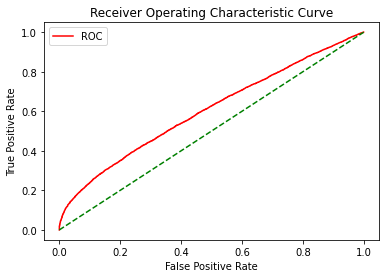

Mahalanobis AUROC score: 0.6037467550000001


In [22]:
fpr, tpr, auroc_score = auroc(test_y, ood_scores)

plot_roc_curve(fpr, tpr)
print('Mahalanobis AUROC score:', auroc_score)

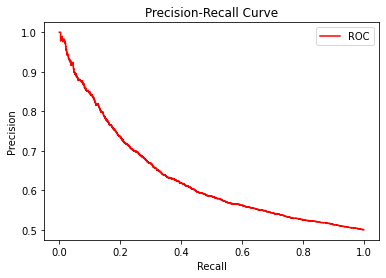

Mahalanobis AUPR score: 0.6322704847596299


In [23]:
precision, recall, aupr_score = aupr(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('Mahalanobis AUPR score:', aupr_score)

In [24]:
fpr95 = fpr_at_95_tpr(test_y, ood_scores)
print('Mahalanobis fpr95 score:', fpr95)

Mahalanobis fpr95 score: 0.9253


#### CIFAR100 vs. CIFAR10

In [39]:
# create ConfigDict from config yaml file
import yaml
from ml_collections import config_dict

config_path = Path('configs') / 'deit_tiny-pretrained-cifar100.yaml'
with config_path.open('r') as f:
    config = yaml.safe_load(f)
    config = config_dict.ConfigDict(config)

In [40]:
from ood_with_vit.metrics.mahalanobis import Mahalanobis

transform_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(dataset_mean, dataset_std),
])      
cifar100 = CIFAR100(
    root=dataset_root, 
    train=True, 
    download=False, 
    transform=transform_test
)
cifar100_train_dataloader = DataLoader(
    dataset=cifar100, 
    batch_size=config.train.batch_size, 
    shuffle=False, 
    num_workers=8
)

model = initialize_vit_model(config)
feature_extractor = FeatureExtractor(
    model=model,
    layer_name=config.model.layer_name.penultimate,
)
mahalanobis = Mahalanobis(config, model, cifar100_train_dataloader, feature_extractor)

Using cache found in /home/simc/.cache/torch/hub/facebookresearch_deit_main
100%|██████████| 98/98 [00:22<00:00,  4.39it/s]


covariance norm: 14.771052072849098


In [41]:
# hook mask_patch
simmim = SimMIMHooker(
    config=config,
    model=model,
    patch_embedding_layer_name='patch_embed.norm',
    mask_ratio=mask_ratio,
)
simmim.hook()

test_y, ood_scores, id_ood_scores, ood_ood_scores = compute_ood_scores(
    metric=mahalanobis,
    in_dist_dataloader=cifar100_test_dataloader,
    out_of_dist_dataloader=cifar10_test_dataloader,
)
print('id mean score:', np.mean(id_ood_scores), 'id variance:', np.var(id_ood_scores))
print('ood mean score:', np.mean(ood_ood_scores), 'ood variance:', np.var(ood_ood_scores))

name: patch_embed.norm
processing in-distribution samples...


100%|██████████| 100/100 [00:07<00:00, 13.78it/s]


processing out-of-distribution samples...


100%|██████████| 100/100 [00:07<00:00, 13.99it/s]

id mean score: 138.97394 id variance: 1928.7738
ood mean score: 138.27644 ood variance: 1980.2152


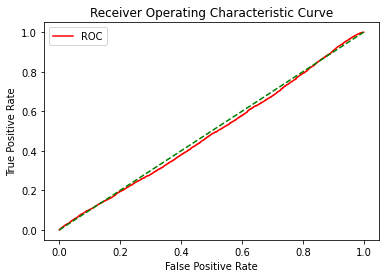

Mahalanobis AUROC score: 0.490357345


In [42]:
fpr, tpr, auroc_score = auroc(test_y, ood_scores)

plot_roc_curve(fpr, tpr)
print('Mahalanobis AUROC score:', auroc_score)

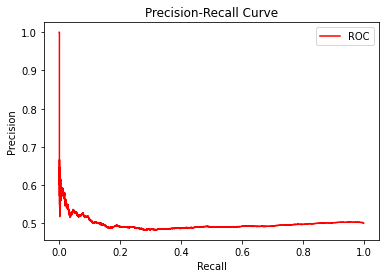

Mahalanobis AUPR score: 0.49773967862172086


In [43]:
precision, recall, aupr_score = aupr(test_y, ood_scores)

plot_precision_recall_curve(precision, recall)
print('Mahalanobis AUPR score:', aupr_score)

In [44]:
fpr95 = fpr_at_95_tpr(test_y, ood_scores)
print('Mahalanobis fpr95 score:', fpr95)

Mahalanobis fpr95 score: 0.9376
